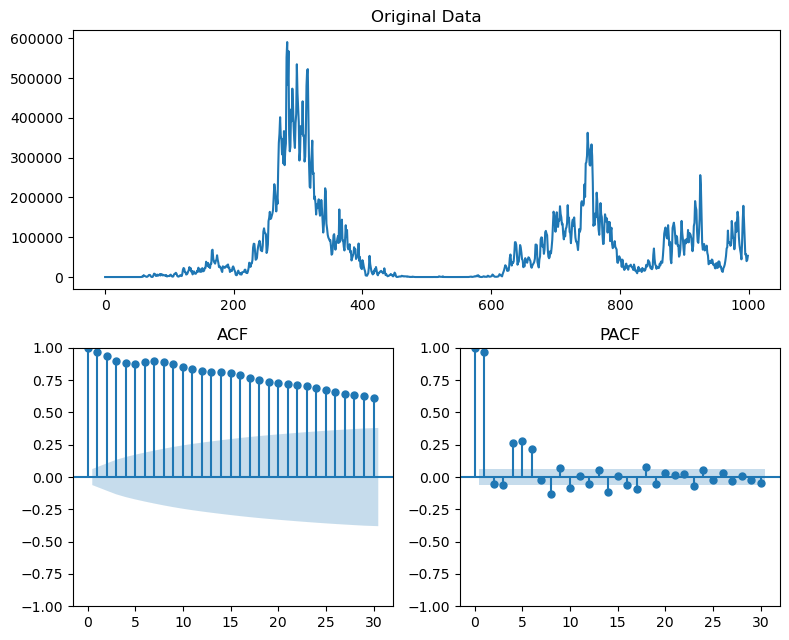

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import numpy as np

test_with_artificial = True

def artificial_arima(p=np.array([]), d=0, q = np.array([]), f=lambda x:x, n = 100, m = 0):
    # generate synthetic data in order to validate our method for real data
    a  = np.random.normal(0,1,n)
    W = np.zeros(n)
    for t in range(n):   
        if t < len(p) and t < len(q):
            W[t] = 0# maybe this can be done cleaner but whatever
        else:
            W[t] = - W[t-len(p):t] @ p[::-1] + a[t] + a[t-len(q):t] @ q[::-1] 
    
    for d_c in range(d):
        W = np.cumsum(W) 
        
    W += m    
        
    return f(W)
    
    


if test_with_artificial:
    points = artificial_arima(
        p = np.array([0,0.1,0.2,0.2,.2]),
        q = np.array([0,0.1,0,0,0]),
        d = 1,
        f = lambda x:x**4,
        n = 1000,
        m = 0.01
    )
    time_series_df = pd.DataFrame({'points': points})
else:
    # Load the CSV file
    data = pd.read_csv('EUR_USD_monthly.csv')
    
    # Extract the time and price series
    time = pd.to_datetime(data.iloc[:, 0])  # Assuming first column is 'time'
    prices = data.iloc[:, 1].replace(',', '', regex=True).astype(float)  # Remove commas and convert to float
    
    
    # Create a DataFrame with the time and prices
    time_series_df = pd.DataFrame({'time': time, 'points': prices})
    time_series_df.set_index('time', inplace=True)

def plot_series_old(series):
    # Plot the time series using Plotly
    series.plot()
    
    plot_acf(series)
    plot_pacf(series)
    
    
def plot_series(series, series_title):
    """
    Plots the time series, ACF, and PACF with custom titles in a 2-column layout.

    Parameters:
    - series: The time series data to plot.
    - series_title: Title for the time series plot.
    """
    # Create a figure with custom layout using gridspec
    fig = plt.figure(figsize=(8, 6.5))
    gs = fig.add_gridspec(2, 2)   # 1 row, 2 columns

    # First column: Time Series plot (span both rows)
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(series)
    ax0.set_title(series_title)

    # Second column: ACF and PACF plots
    # ACF plot
    ax1 = fig.add_subplot(gs[1, 0])
    plot_acf(series, ax=ax1)
    ax1.set_title("ACF")

    # PACF plot
    ax2 = fig.add_subplot(gs[1, 1])  # Reuse the same axis for PACF
    plot_pacf(series, ax=ax2)
    ax2.set_title("PACF")

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    
plot_series(time_series_df['points'], "Original Data")


Use a full automatic test to which we can compare our results to

In [22]:
if False:
    import pmdarima as pm
    
    # Automatically fit the best ARIMA/SARIMA model
    model = pm.auto_arima(
        time_series_df,
        seasonal=False,      # Enable seasonal differencing if necessary
        stepwise=True,      # Use stepwise algorithm for faster computation
        trace=True,         # Show the fitting process details
        max_p=7,              # Set maximum p value to control AR component
        max_q=7,              # Set maximum q value to control MA component
        max_d=1,              # Set maximum differencing order
        max_P=1,              # Set maximum seasonal AR order
        max_Q=1,              # Set maximum seasonal MA order
        max_D=1,
        max_order = 10
    )
    
    
    # Summary of the best model found
    print(model.summary())
    
    # Predict future values (e.g., next 12 periods)
    forecast = model.predict(n_periods=12)


Test stationarity, Augmented Dickey-Fuller unit root test.

In [23]:
#Check stationarity
# alternative hypothesis is stationarity 
st.adfuller(time_series_df['points'])


(-2.840829887455817,
 0.052674037318830205,
 18,
 981,
 {'1%': -3.4370334797663844,
  '5%': -2.8644907213150725,
  '10%': -2.568341114581742},
 22252.036740704603)

p value > 0.05 => we can not conclude stationarity

apply box cox transformation, and use scipy to estimate optimal box cox parameter lambda (todo explain what method scipy uses)

used lambda:  0.20996271649632617


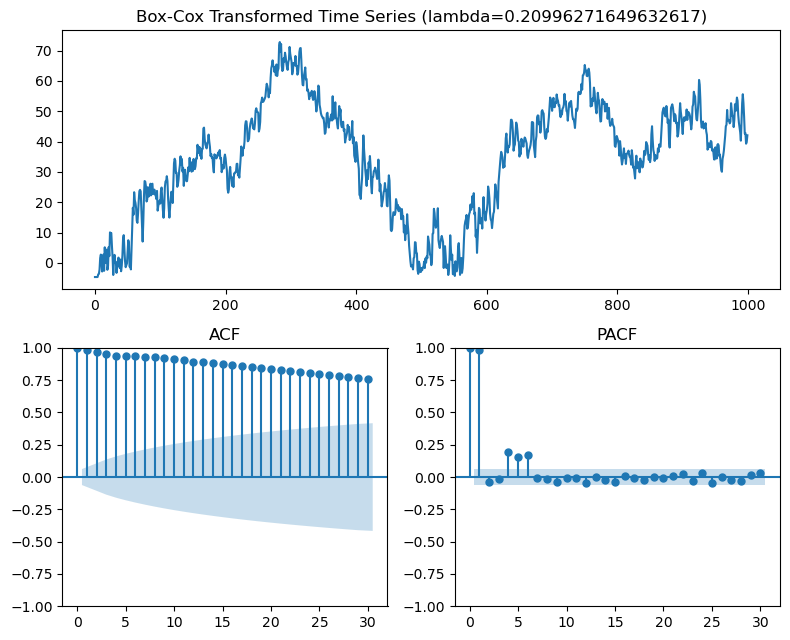

In [24]:
from scipy import stats
use_trafo = True
if use_trafo:
    # Apply Box-Cox transformation and estimate lambda
    lmbda = None
    if lmbda is None:
        transformed_prices, lmbda = stats.boxcox(time_series_df["points"])
    else:
        transformed_prices = stats.boxcox(time_series_df["points"], lmbda =lmbda)
    
    # Store the transformed values back into the DataFrame
    time_series_df['T_points'] = transformed_prices
    print("used lambda: ", lmbda)
else:
    time_series_df['T_points'] = time_series_df['points']
plot_series(time_series_df['T_points'], f"Box-Cox Transformed Time Series (lambda={lmbda})")
    


Differentiate and see when stationarity tests become positive

In [25]:
alpha = 0.005

        

# Assuming 'time_series_df' is your DataFrame and 'Prices' is the column
current_series = time_series_df['T_points'] # todo possible bug, try with_: pd.DataFrame(np.random.random(100))#np.exp(time_series_df['boxcox_points'])
differencing_count = 0

# Function to apply ADF test and get p-value
def get_adf_p_value(series):
    adf_result = st.adfuller(series.dropna())
    return adf_result[1]  # Return p-value from ADF test

# Keep iterating until the series is stationary or we reach the max differencing
while get_adf_p_value(current_series) >= alpha:
    differencing_count += 1
    # Apply first-order differencing
    current_series = current_series.diff()

    # Add the differenced series to the DataFrame
    time_series_df['diff_points'] = current_series
    # Print progress with the p-value after differencing
    print(f"After {differencing_count} differencing(s), the ADF p-value is: {get_adf_p_value(current_series)}")


# Check if series is stationary after differencing
if get_adf_p_value(current_series) < alpha:
    print(f"Series is stationary after {differencing_count} differencings.")
    print("")
else:
    print("Max differencings reached without achieving stationarity.")





After 1 differencing(s), the ADF p-value is: 0.0
Series is stationary after 1 differencings.



Plot the new time series and acf and pcf

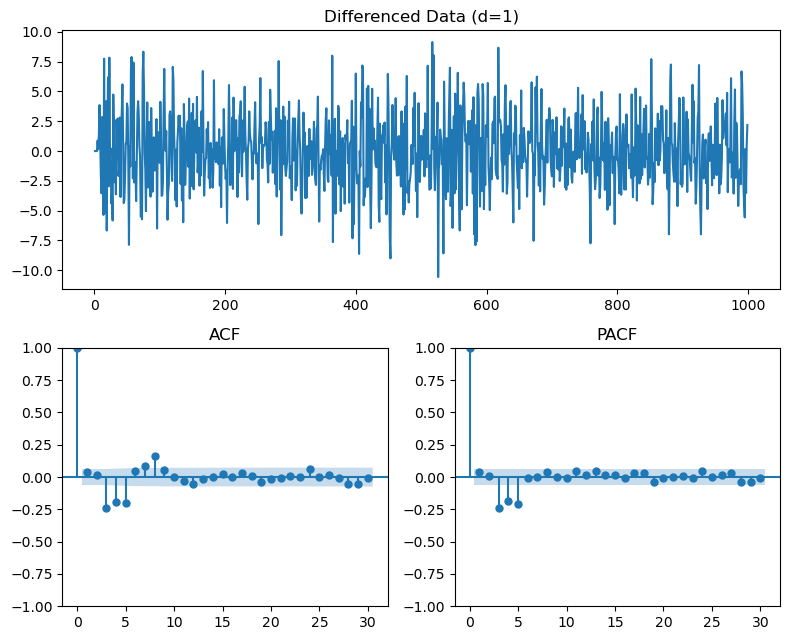

In [26]:
plot_series(time_series_df['diff_points'].dropna(), f"Differenced Data (d={differencing_count})")


Print significant auto and partial autocorelations

In [30]:
print(st.acf(time_series_df['diff_points'].dropna(), qstat=True))

(array([ 1.00000000e+00,  3.73100317e-02,  1.32432746e-02, -2.37792710e-01,
       -1.93133867e-01, -2.02890174e-01,  5.02586584e-02,  8.74582795e-02,
        1.62239709e-01,  5.72132080e-02,  3.69267983e-03, -3.34740322e-02,
       -5.15563251e-02, -1.15752320e-02,  3.29036065e-03,  2.49047887e-02,
       -3.26601298e-03,  3.04412160e-02,  9.82918938e-03, -3.47396049e-02,
       -1.45303615e-02, -5.68479072e-03,  1.00319362e-02,  4.16102383e-03,
        6.12946911e-02, -5.65513546e-04,  1.25512982e-02, -6.29029469e-03,
       -5.24447527e-02, -5.40305425e-02]), array([  1.39482672,   1.57073861,  58.34314448,  95.83123817,
       137.24409696, 139.78783334, 147.49846137, 174.05920489,
       177.36561691, 177.37940444, 178.51352358, 181.20658538,
       181.34247368, 181.35346502, 181.98379823, 181.99464953,
       182.93830198, 183.03678605, 184.26825436, 184.48391441,
       184.51695819, 184.61996703, 184.63770689, 188.49107653,
       188.49140488, 188.65331128, 188.69401886, 191.